In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
os.listdir("/kaggle/input/skin-cancer-malignant-vs-benign")
os.listdir("/kaggle/input/skin-cancer-malignant-vs-benign")

['data', 'test', 'train']

In [3]:
train_dir='/kaggle/input/skin-cancer-malignant-vs-benign/train/'
test_dir='/kaggle/input/skin-cancer-malignant-vs-benign/test/'

ben_dir = "/kaggle/input/skin-cancer-malignant-vs-benign/train/benign"
malig_dir = "/kaggle/input/skin-cancer-malignant-vs-benign/train/malignant"

# train_dir = "/content/drive/MyDrive/skin_dataset_resized/train_set/"
# test_dir = "/content/drive/MyDrive/skin_dataset_resized/test_set/"
# val_dir = "/content/drive/MyDrive/skin_dataset_resized/val_set/"

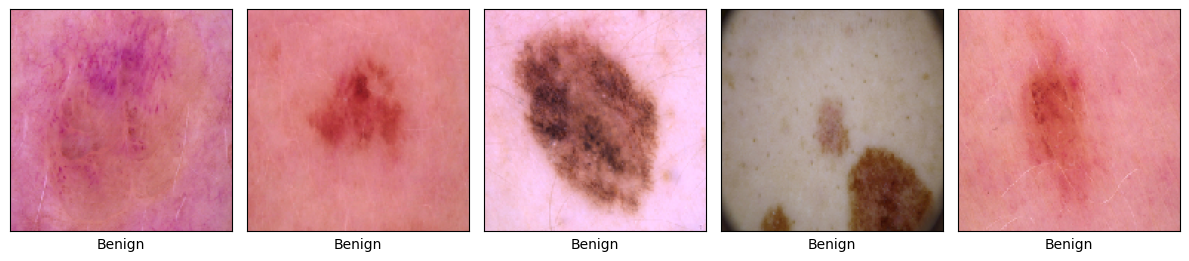

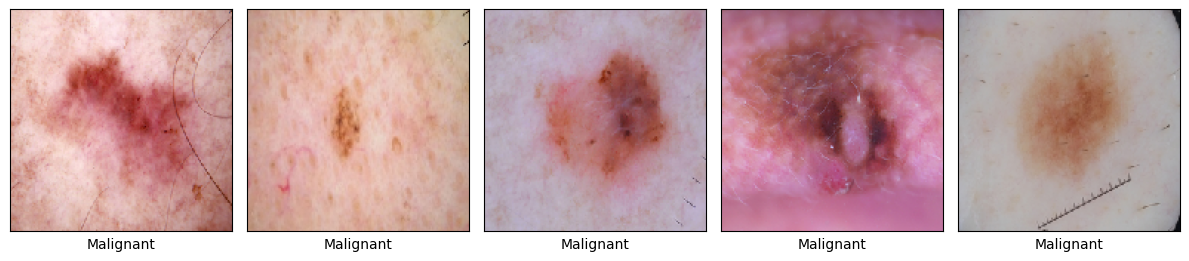

In [4]:
import random
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing.image import load_img
plt.figure(figsize=(12,7))
ben = random.sample(os.listdir(ben_dir),5)
malig = random.sample(os.listdir(malig_dir),5)

for i,img in enumerate(ben):
    path = os.path.join(ben_dir,img)
    img = load_img(path, target_size=(150,150))
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.xlabel("Benign")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout();

plt.figure(figsize=(12,7))
for i,img in enumerate(malig):
    path = os.path.join(malig_dir,img)
    img = load_img(path, target_size=(150,150))
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.xlabel("Malignant")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout();

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale =(1./255),rotation_range=0.2,
    width_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    fill_mode='nearest',
    horizontal_flip= True,
    validation_split=0.2)

val_datagen = ImageDataGenerator(rescale =(1./255))

train_data = train_datagen.flow_from_directory(directory = train_dir, 
                                               target_size =(224,224),
                                               class_mode = "categorical",
                                               batch_size =32,
                                               subset='training')
val_data = train_datagen.flow_from_directory(directory = train_dir, 
                                               target_size =(224,224),
                                               class_mode = "categorical",
                                               batch_size =32,
                                                subset='validation')
test_data = val_datagen.flow_from_directory(directory = test_dir, 
                                               target_size =(224,224),
                                               class_mode = "categorical",
                                               batch_size =32)

Found 2110 images belonging to 2 classes.
Found 527 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


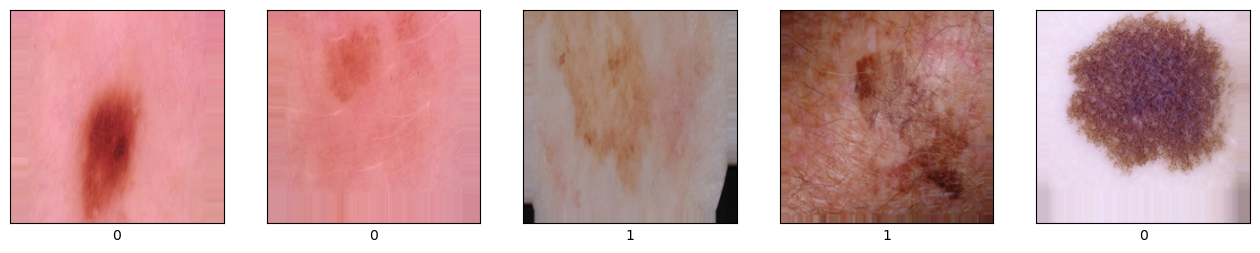

In [6]:
from tensorflow.keras.preprocessing import image
sample_x, sample_y = next(train_data)
plt.figure(figsize=(16,9))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = image.img_to_array(sample_x[i])
    plt.imshow(img)
    plt.xlabel(np.argmax(sample_y[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [7]:
from tensorflow.keras.applications import DenseNet121
dense = DenseNet121(weights = "imagenet", include_top = False, input_shape=(224,224,3))

29084464/29084464 [==============================] - 2s 0us/step


In [8]:
for layer in dense.layers[:121]:
    layer.trainable = False

In [9]:
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization

model = Sequential()
model.add(dense)
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512,activation= "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

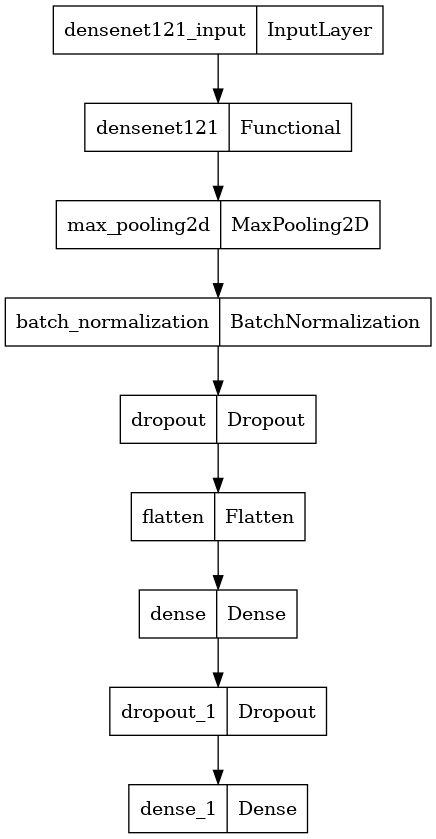

In [10]:
plot_model(model,
    to_file='DenseNet.png',
    show_shapes=False,
    show_layer_names=True)

In [11]:
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam
metrics = ['accuracy']

lr=0.001
model.compile(optimizer = Adam(learning_rate = 0.001), loss = "categorical_crossentropy", metrics = metrics)

In [12]:
patience = 1
stop_patience = 3
factor = 0.5
#    tf.keras.callbacks.EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1),
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("densenet121.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1)
]

In [13]:
history = model.fit(train_data, validation_data = test_data, epochs = 10, 
                    verbose = 1, callbacks = callbacks )

Epoch 1/10


2023-07-12 13:05:38.030742: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/66 [==============================] - 112s 815ms/step - loss: 0.6874 - accuracy: 0.7815 - val_loss: 1.5111 - val_accuracy: 0.8212 - lr: 0.0010
Epoch 2/10
66/66 [==============================] - ETA: 0s - loss: 0.3183 - accuracy: 0.8555
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
66/66 [==============================] - 30s 460ms/step - loss: 0.3183 - accuracy: 0.8555 - val_loss: 1.5245 - val_accuracy: 0.8121 - lr: 0.0010
Epoch 3/10
66/66 [==============================] - 32s 488ms/step - loss: 0.2427 - accuracy: 0.8863 - val_loss: 0.4583 - val_accuracy: 0.8561 - lr: 5.0000e-04
Epoch 4/10
66/66 [==============================] - 32s 488ms/step - loss: 0.2193 - accuracy: 0.9019 - val_loss: 0.3366 - val_accuracy: 0.8333 - lr: 5.0000e-04
Epoch 5/10
66/66 [==============================] - ETA: 0s - loss: 0.2183 - accuracy: 0.9024
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
66/66 [==============================] - 32s 474m

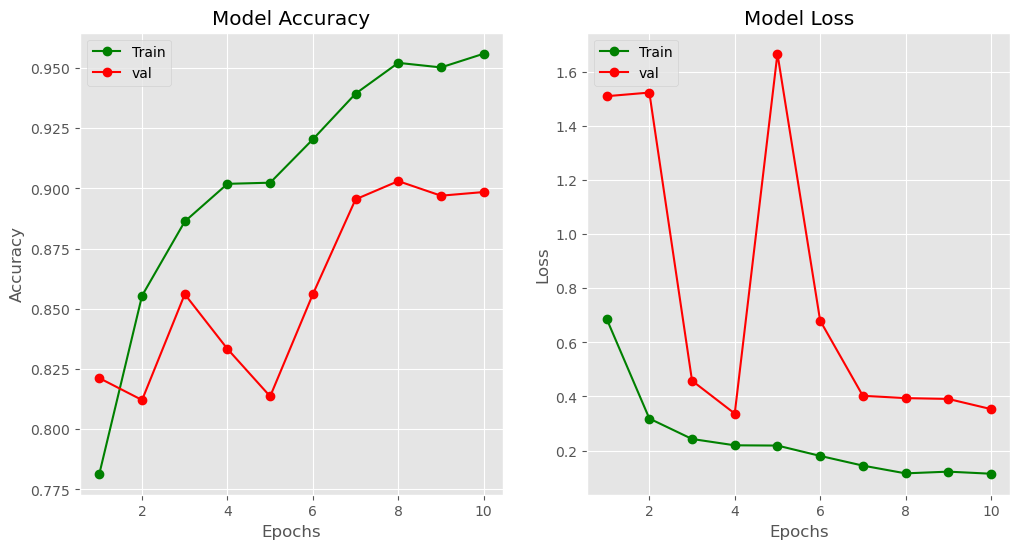

In [14]:
epoch=10
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,11)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")
#plt.show()

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()